In [103]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

from plotly import express as px
import cufflinks
cufflinks.go_offline()

from pprint import pprint
from glob import glob
from tqdm.notebook import tqdm_notebook as tqdm

import sys
sys.path.append('../')

from src.data.gibdd_filter import GibddFilter
from src.data import normalize_name

import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
pd.read_parquet('../data/processed/gibdd.parquet').sample(10)

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,...,mass_idle,inn,region,city,body_type,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,
2017-03-20,1125,С,2017-03-20,MITSUBISHI,CANTER,MDT2,С,4x2,2014.0,Z9MFE85DJBG005909,...,4890.0,3811081969,None,ИРКУТСК Г.,Автокран,Торговля,Иркутская область,Сибирский ФО,Сибирский ФО,"Изменение собственника по сделкам, произведенн..."
2013-12-20,1180,С,2013-12-20,КАМАЗ,43118,HDT2,О,6x6,2013.0,X5W5668CKD0000052,...,11520.0,0265025836,Г. ОКТЯБРЬСКИЙ,ОКТЯБРЬСКИЙ Г.,Агрегат для сбора нефтепродуктов,None,Башкортостан,Приволжский ФО,Приволжский ФО,первичная регистрация
2014-07-29,1157,С,2001-01-01,МАЗ,6312А9,HDT3,И,6x4,2012.0,Y3M6312A9C0000702,...,10250.0,5920029183,ЧАЙКОВСКИЙ Р-Н,Г. ЧАЙКОВСКИЙ,Бортовой,None,Пермский край,Приволжский ФО,Приволжский ФО,"Изменение собственника по сделкам, произведенн..."
2017-07-21,1140,С,2017-07-21,КАМАЗ,53215,HDT3,О,6x4,2008.0,XVN45717K80103188,...,19500.0,7805698006,None,None,Автокран,Строительная,Санкт-Петербург,Северо-Западный ФО,Северо-Западный ФО,"Изменение собственника по сделкам, произведенн..."
2018-01-20,1125,С,NaT,MERCEDES-BENZ,3346,HDT3,С,6x4,2017.0,X89697CB6H5ER2020,...,13300.0,3811111733,None,Г ХАБАРОВСК,Сортиментовоз,Лизинговая компания,Иркутская область,Сибирский ФО,Сибирский ФО,первичная регистрация
2014-02-04,1144,С,2014-02-04,НЕФАЗ,66061,HDT3,О,6x4,2013.0,X1F66061RD0000274,...,9090.0,4909047148,ЯГОДНИНСКИЙ,СИНЕГОРЬЕ П,Цистерна,Энергетика,Магаданская область,Дальневосточный ФО,Дальневосточный ФО,первичная регистрация
2018-01-12,1176,С,2018-01-12,SHAANXI MAN,SX3256,HDT3,И,6x4,2013.0,LZGJLDR46DX056653,...,14350.0,None,ЭХИРИТ-БУЛАГАТСКИЙ Р-Н.,П УСТЬ-ОРДЫНСКИЙ,Самосвал,ФИЗ ЛИЦО,Забайкальский край,Сибирский ФО,Сибирский ФО,"Изменение собственника по сделкам, произведенн..."
2013-12-18,1140,С,2013-12-18,HYUNDAI,HD120,HDT1,И,4x2,2007.0,X9H47432A70000017,...,5170.0,7802807271,ВЫБОРГСКИЙ (ГОР),Г.САНКТ-ПЕТЕРБУРГ,Фургон,None,Санкт-Петербург,Северо-Западный ФО,Северо-Западный ФО,"Изменение собственника по сделкам, произведенн..."
2020-01-31,1166,С,2020-01-31,МАЗ,555102,HDT2,И,4x2,2006.0,Y3M55510260009963,...,8000.0,6623122216,ЯРЦЕВСКИЙ Р-Н.,Г ЯРЦЕВО,Самосвал,Металлургия,Смоленская область,Центральный ФО,Центральный ФО,"Изменение собственника по сделкам, произведенн..."


In [104]:
df = pd.read_parquet('../data/processed/gibdd.parquet')
df = df[df['operation_reason'] == 'первичная регистрация']

df.shape

(444288, 24)

In [107]:
MIN_VIN_PER_INN = 30

tmp = df.groupby('inn')['vin'].nunique() 
inn_list = np.asarray(tmp[tmp >= MIN_VIN_PER_INN].index)

df = df[df['inn'].isin(inn_list)]
inn2vin_dict = df.groupby('inn')['vin'].agg(set).to_dict()

In [212]:
inn = np.random.choice(df['inn'].unique())
tmp_structure = df.loc[df['inn'] == inn][['vin', 'body_type', 'brand']].drop_duplicates('vin', keep='first')

In [228]:
def prep_brand_struct(df, inn, top=3):

    tmp = df['brand'].value_counts().head(top).to_frame().reset_index()
    tmp.columns = ['brand_name', 'brand_size']

    tmp = tmp.T
    tmp.columns = ['Top_'+str(col+1) for col in list(tmp)]

    tmp = tmp.stack().to_frame().T
    tmp.columns = ['_'.join(col[::-1]) for col in tmp.columns]
    
    return tmp

In [229]:
def prep_body_struct(df, inn, top=3):


    tmp = df['body_type'].value_counts().head(top).to_frame().reset_index()
    tmp.columns = ['body_name', 'body_size']

    tmp = tmp.T
    tmp.columns = ['Top_'+str(col+1) for col in list(tmp)]

    tmp = tmp.stack().to_frame().T
    tmp.columns = ['_'.join(col[::-1]) for col in tmp.columns]
    
    return tmp

## PREP CARPARK STRUCTURE

In [244]:
body_list = []
brand_list = []
for inn in tqdm(inn2vin_dict.keys()):
    tmp_structure = df.loc[df['inn'] == inn][['vin', 'body_type','brand']].drop_duplicates('vin', keep='first')
    body_list.append(prep_body_struct(tmp_structure, inn, 3))
    brand_list.append(prep_brand_struct(tmp_structure, inn, 3))

df_body = pd.concat(body_list)
df_body.index = inn2vin_dict.keys()

df_brand = pd.concat(brand_list)
df_brand.index = inn2vin_dict.keys()
df_brand

In [251]:
df_brand = df_brand.loc[:,['Top_1_brand_name', 'Top_1_brand_size', 'Top_2_brand_name', 'Top_2_brand_size', 'Top_3_brand_name', 'Top_3_brand_size',]]

df_body = df_body.loc[:, ['Top_1_body_name', 'Top_1_body_size', 'Top_2_body_name', 'Top_2_body_size', 'Top_3_body_name', 'Top_3_body_size',]]

df_struct = pd.concat((df_brand, df_body), axis=1)

In [264]:
pd.read_excel('../reports/data/carpark_update_freq.xlsx', index_col=[0]).merge(df_struct, left_index=True, right_index=True, how='left').to_excel('../reports/data/carpark_struct_update.xlsx')

## PREP TRANSACTION STRUCTURE

In [44]:
len_list = []
sum_list = []
mean_list = []
median_list = []
max_list = []
last_list = []

for inn in tqdm(inn2vin_dict.keys()):
    series = df.loc[df['vin'].isin(inn2vin_dict[inn]), 'vin'].drop_duplicates().resample('1M').count()
    
    tmp = series.replace(0, np.nan).dropna()

    len_list.append(len(tmp))
    sum_list.append(tmp.sum())
    mean_list.append(tmp.mean())
    median_list.append(tmp.median())
    max_list.append(tmp.max())
    last_list.append(tmp.index[-1].year)

In [57]:
res = pd.DataFrame(index=inn2vin_dict.keys())

res['n_transaction'] = len_list
res['carpark_size'] = sum_list
res['mean'] = mean_list
res['median'] = median_list
res['max'] = max_list
res['last_year'] = last_list

res = res[res['last_year'] >= 2019]

# RESULT

In [96]:
tmp = res.query('(carpark_size < 100) and (n_transaction > 5)').sort_values('n_transaction')

# PLOT INN

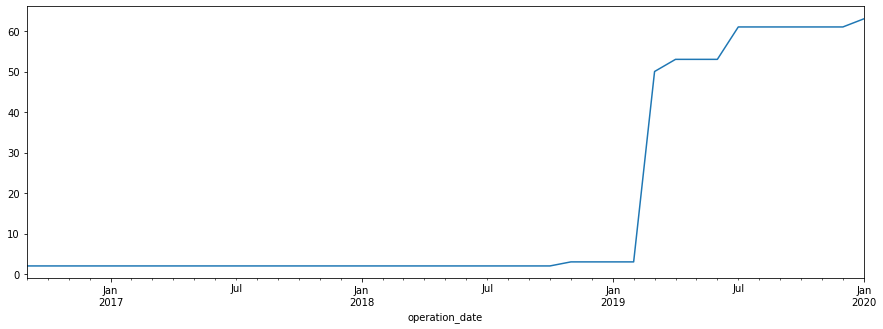

In [101]:
rand_inn = '7743096224'


tmp = df.loc[df['vin'].isin(inn2vin_dict[rand_inn]), ['vin']].drop_duplicates(keep='first')
tmp['vin'].resample('1M').count().cumsum().plot(figsize=(15,5))
plt.show()

In [97]:
tmp

,n_transaction,carpark_size,mean,median,max,last_year
7743096224,6,63.0,10.500000,2.5,47.0,2020
3109004337,6,75.0,12.500000,10.0,31.0,2019
6449072121,6,30.0,5.000000,4.5,10.0,2019
3665144287,6,36.0,6.000000,6.0,10.0,2020
7728623959,6,36.0,6.000000,5.0,15.0,2019
...,...,...,...,...,...,...
1650081520,39,96.0,2.461538,2.0,9.0,2020
2801099482,39,94.0,2.410256,2.0,9.0,2020
7704784450,39,86.0,2.205128,1.0,19.0,2020
7705002602,39,75.0,1.923077,2.0,6.0,2020


In [92]:
res

,n_transaction,carpark_size,mean,median,max,last_year
0105057460,25,40.0,1.600000,1.0,4.0,2020
0107008235,19,42.0,2.210526,1.0,7.0,2019
0263012310,13,46.0,3.538462,3.0,12.0,2019
0264015786,28,64.0,2.285714,1.0,10.0,2020
0264051632,12,46.0,3.833333,5.0,6.0,2019
...,...,...,...,...,...,...
9909004922,34,170.0,5.000000,4.0,19.0,2020
9909005806,17,50.0,2.941176,1.0,15.0,2020
9909012867,38,136.0,3.578947,2.5,13.0,2020
9909050372,12,40.0,3.333333,3.5,10.0,2020


In [102]:
df

,coato,vehicle_type,registration_date,brand,model,class,origin,chassis_config,year,vin,primary,affiliation,code,mass_max,mass_idle,inn,region,city,activity_field,Наименование,Федеральный округ до 2011,Федеральный округ,operation_reason
operation_date,,,,,,,,,,,,,,,,,,,,,,,
2013-01-10,1146,С,2001-01-01,УРАЛ,5557,HDT2,О,6x6,2012.0,XVN357140C0202891,11,1,53,NaN,18240.0,7736050003,ИСТРИНСКИЙ Р-Н,КОСТРОВСКОЕ С|П КОСТРОВО,Нефтегазодобывающая,Московская область,Центральный ФО,Центральный ФО,первичная регистрация
2013-01-10,1146,С,2001-01-01,VOLVO,FES,HDT3,И,4x2,2012.0,YV2VBM0A8DB643535,11,1,3,NaN,7146.0,7705034202,СОЛНЕЧНОГОРСКИЙ Р-Н,СОЛНЕЧНОГОРСК,None,Московская область,Центральный ФО,Центральный ФО,первичная регистрация
2013-01-11,1146,С,2001-01-01,MAN,41.440,HDT3,И,8x4,2012.0,X3W65392AC0001126,11,1,5,NaN,15500.0,5018059580,КОРОЛЕВСКИЙ,КОРОЛЕВ,Строительная,Московская область,Центральный ФО,Центральный ФО,первичная регистрация
2013-01-11,1146,С,2001-01-01,MAN,41.440,HDT3,И,8x4,2012.0,X3W65392AC0001120,11,1,5,NaN,15500.0,5018059580,КОРОЛЕВСКИЙ,КОРОЛЕВ,Строительная,Московская область,Центральный ФО,Центральный ФО,первичная регистрация
2013-01-11,1146,С,2001-01-01,MAN,41.440,HDT3,И,8x4,2012.0,X3W65392AC0001123,11,1,5,NaN,15500.0,5018059580,КОРОЛЕВСКИЙ,КОРОЛЕВ,Строительная,Московская область,Центральный ФО,Центральный ФО,первичная регистрация
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,1122,С,2020-03-06,ГАЗ,33081,MDT1,О,4x4,2019.0,XUY3813GCL0000778,11,1,1.0,NaN,5000.0,5260200603,None,Г НИЖНИЙ НОВГОРОД,None,Нижегородская область,Приволжский ФО,Приволжский ФО,первичная регистрация
2020-03-06,1122,С,2020-03-06,ГАЗ,33088,MDT1,О,4x4,2019.0,XUY3813G0L0000809,11,1,55.0,NaN,5450.0,5260200603,None,Г НИЖНИЙ НОВГОРОД,None,Нижегородская область,Приволжский ФО,Приволжский ФО,первичная регистрация
2020-03-06,1122,С,2020-03-06,ГАЗ,33088,MDT1,О,4x4,2019.0,XUY3813G0L0000810,11,1,55.0,NaN,5450.0,5260200603,None,Г НИЖНИЙ НОВГОРОД,None,Нижегородская область,Приволжский ФО,Приволжский ФО,первичная регистрация
